In [2]:
import torch 
from torch.utils.data import Dataset, DataLoader 
import joblib
from utils.preprocess_data_KDD_plus_test import preprocess_data
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
import torch.nn as nn
import torch.optim as optim

In [23]:
from utils.loss_func import CustomFocalLoss
from utils.metrics import ClassBasedAccuracy
from utils.plot import plot_data_distribution

In [5]:
# # Uncomment the following to create a new preprocessing pipeline for the first time
# pipeline = joblib.load("preprocessing_pipeline/pipeline.pkl")
# label_encoder = joblib.load("preprocessing_pipeline/attack_label_encoder.pkl")

In [12]:
class IntrusionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        sample = self.X[idx]
        label = self.y[idx]
        sample = torch.tensor(sample, dtype = torch.float32)
        sample = sample.unsqueeze(0) # Add a channel dimension [1, 16] & after dataloader [batch size, 1, 16]
        return sample, torch.tensor(label, dtype=torch.long)
        # Pytorch expects labels to be in torch.long format and float32 for features simply because of memory efficiency

In [13]:
# Specify file paths
train_file_path = os.path.join('data', 'train_split.csv')
val_file_path = os.path.join('data', 'valid_split.csv')
test_file_path = os.path.join('data', 'test_split.csv')

preprocessing_models_folder = os.path.join('preprocessing_pipeline')

# Load datasets
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(
    train_file_path=train_file_path,
    val_file_path=val_file_path,
    test_file_path=test_file_path,
    preprocessing_models_folder=preprocessing_models_folder
)


In [14]:
X_train.shape, X_val.shape, X_test.shape

((118315, 16), (14789, 16), (14790, 16))

In [15]:
y_train.shape, y_val.shape, y_test.shape

((118315,), (14789,), (14790,))

In [16]:
X_train[0], y_train[0]

(array([ 1.98644883, -0.86532665,  0.47526487, -1.00654487,  0.69387046,
         0.52524963, -0.2053507 ,  0.00220931, -0.04360147,  0.29817474,
        -0.48461176,  0.32805525,  0.09835973,  0.04107148,  0.62991672,
         0.30032341]),
 np.int64(4))

In [17]:
type(X_train)

numpy.ndarray

/home/mejan/projects/intrusion/intrusion_multifile/utils/plot.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_mapped, ax=axes[0], palette="Set2")
/home/mejan/projects/intrusion/intrusion_multifile/utils/plot.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_valid_mapped, ax=axes[1], palette="Set2")
/home/mejan/projects/intrusion/intrusion_multifile/utils/plot.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test_mapped, ax=axes[2], palette="Set2")


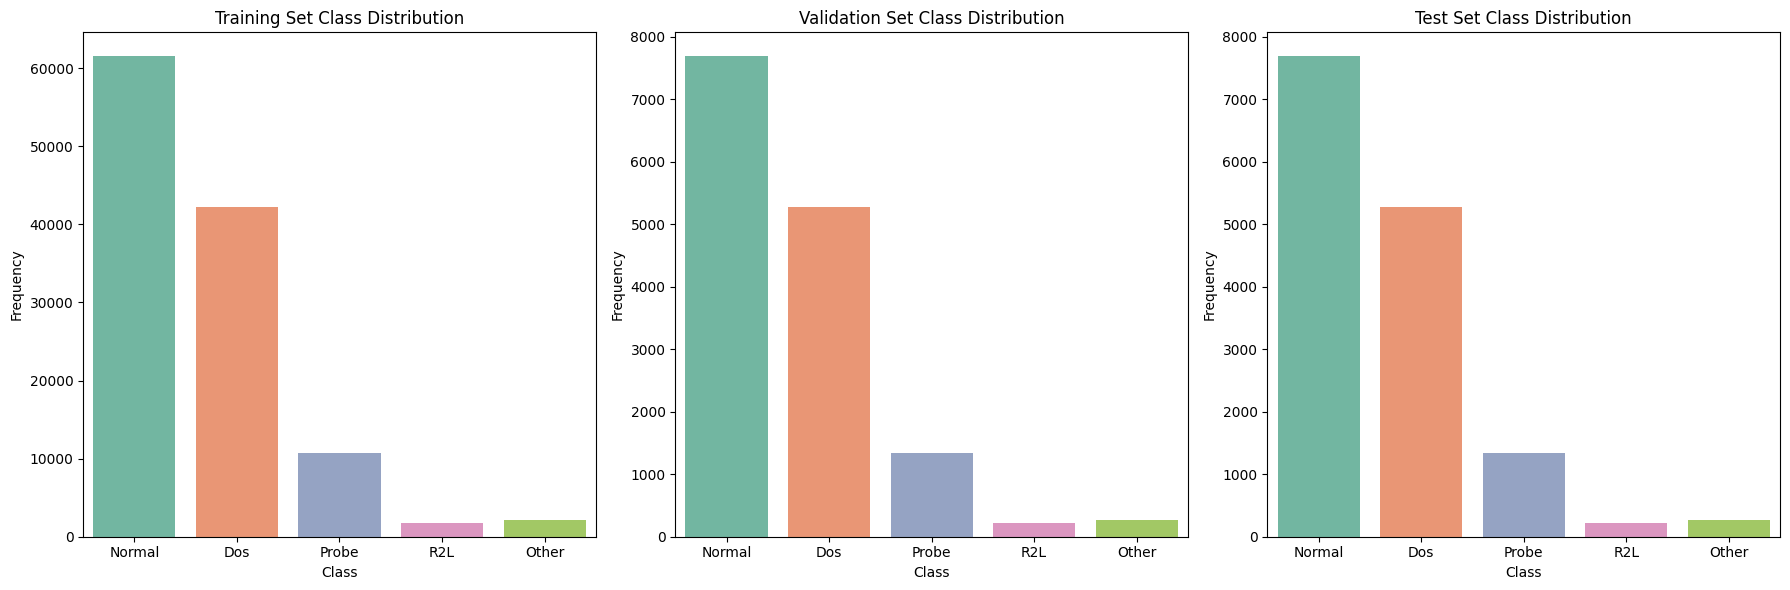

Saved distribution plot as img/data_dist_KDD_2.png


<Figure size 640x480 with 0 Axes>

In [24]:
lookup = {0:"Dos", 1:"Other", 2:"Probe", 3:"R2L", 4:"Normal"}
plot_data_distribution(y_train, y_val, y_test, out_path="img", lookup=lookup)

{'Dos': 6898, 'Normal': 9711, 'Probe': 1931, 'Other': 1787, 'R2L': 2148}


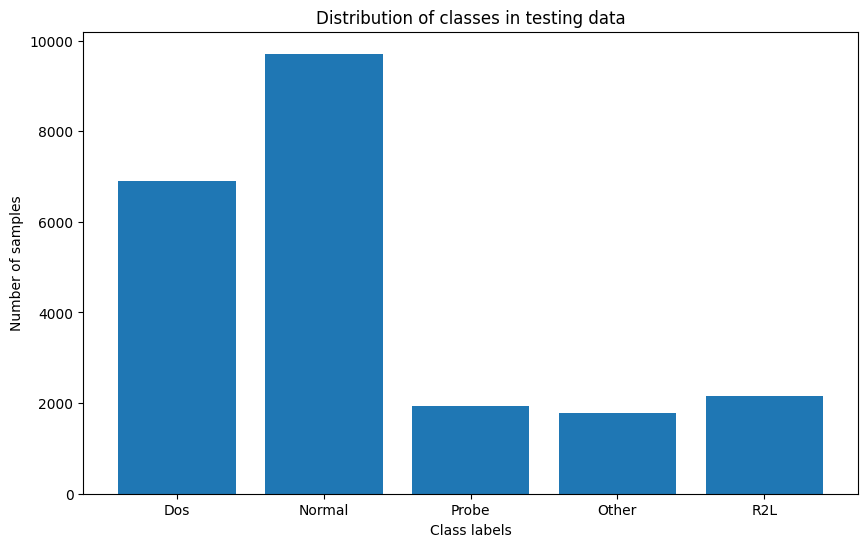

In [13]:
# class_counts = {}
# for label in y_test:
#     class_counts[label]=class_counts.get(label, 0)+1

# lookup = {0:"Dos", 1:"Other", 2:"Probe", 3:"R2L", 4:"Normal"}
# class_counts_labeled = {lookup.get(k, k): v for k, v in class_counts.items()}
# print(class_counts_labeled)
# plt.figure(figsize=(10,6))
# plt.bar(class_counts_labeled.keys(), class_counts_labeled.values())
# plt.title('Distribution of classes in testing data')
# plt.xlabel('Class labels')
# plt.ylabel('Number of samples')
# plt.xticks()
# plt.show()

In [25]:
train_dataset = IntrusionDataset(X_train, y_train)
test_dataset = IntrusionDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [26]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([1, 16]), torch.Size([]))

In [27]:
train_dataset[0]

(tensor([[ 1.9864, -0.8653,  0.4753, -1.0065,  0.6939,  0.5252, -0.2054,  0.0022,
          -0.0436,  0.2982, -0.4846,  0.3281,  0.0984,  0.0411,  0.6299,  0.3003]]),
 tensor(4))

In [17]:
next(iter(train_loader))

[tensor([[[ 2.4192e+00, -8.9605e-01, -4.7366e-01, -8.7662e-01,  4.1592e-01,
            2.4039e-01, -1.7455e-01,  1.5565e-03, -2.2537e-02,  1.6378e-01,
           -2.5943e-01, -5.6722e-01, -6.2567e-01,  8.7770e-02, -2.0076e-01,
            1.6717e-01]],
 
         [[ 5.5019e-01, -3.8694e-01,  7.0954e+00,  1.1617e+00, -2.4404e+00,
           -5.7319e-01, -2.2996e-01,  5.2706e-02,  1.0834e-01, -3.0517e-01,
            3.5324e-01, -1.7306e-01, -1.7681e-01,  3.1497e-01, -1.6238e+00,
           -2.7718e-01]],
 
         [[-1.3948e-01, -4.7808e-01, -3.2130e-01,  3.2015e-01,  7.9972e-01,
            4.8641e-01,  9.6760e-02,  1.0673e-02,  4.4810e-03,  4.8713e-02,
           -3.3225e-01,  1.9306e-02,  1.7860e+00,  1.1250e-01, -6.8932e-01,
           -1.7830e-01]],
 
         [[ 2.7497e+00, -8.4342e-01, -7.3454e-01,  1.3367e-01, -2.0071e-01,
           -3.4651e-03, -1.6562e-01,  1.4700e-02, -2.4952e-02, -9.6997e-02,
           -1.4858e-01, -1.4249e+00, -8.1148e-01, -3.1699e-01,  2.4930e-01,
    

We will implement the following CNN architecture from the paper:

"Effectiveness of Focal Loss for Minority Classification in Network Intrusion Detection Systems"
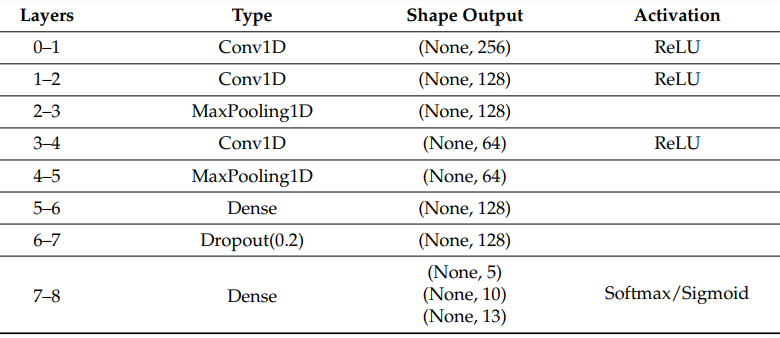

In [28]:
class CustomCNN(nn.Module):
    def __init__(self, output_classes, input_length = 16):
        super().__init__()

        # Conv1D -> (None, 256)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        
        # Conv1D -> (None, 128)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        
        # MaxPooling1D -> (None, 128)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Conv1D -> (None, 64)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        # MaxPooling1D -> (None, 64)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Dense -> (None, 128)
        self.fc1 = nn.Linear(64 * input_length // 4, 128)  # Adjust input size based on pooling
        self.relu4 = nn.ReLU()
        
        # Dropout -> (None, 128)
        self.dropout = nn.Dropout(0.2)
        
        # Output layer(s)
        self.fc2 = nn.Linear(128, output_classes)  # Final dense layer
        
    def forward(self, x):
        # Pass through Conv1D layers
        # print(f"Input shape: {x.shape}")
        x = self.relu1(self.conv1(x))
        # print(f"After conv1: {x.shape}")
        x = self.relu2(self.conv2(x))
        # print(f"After conv2: {x.shape}")
        x = self.pool1(x)
        # print(f"After pool1: {x.shape}")
        x = self.relu3(self.conv3(x))
        # print(f"After conv3: {x.shape}")
        x = self.pool2(x)
        # print(f"After pool2: {x.shape}")
        
        # Flatten before passing into Dense layers
        x = x.view(x.size(0), -1)
        # print(f"After flatten: {x.shape}")
        
        # Fully connected layers
        x = self.relu4(self.fc1(x))
        # print(f"After fc1: {x.shape}")
        x = self.dropout(x)
        # print(f"After dropout: {x.shape}")
        x = self.fc2(x)
        # print(f"After fc2 (output): {x.shape}")
        
        return x

In [29]:
out_classes = 5
model = CustomCNN(out_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [30]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
def compute_inverse_freq_weights(labels, num_classes):
    """
    Compute inverse frequency weights for each class using a mask.
    
    Args:
    - labels (np.ndarray): A NumPy array of shape (N,) containing class labels.
    - num_classes (int): The total number of classes.
    
    Returns:
    - torch.Tensor: A tensor containing inverse frequency weights for each class.
    """
    # Convert labels to a torch tensor
    labels = torch.tensor(labels, dtype=torch.long)

    # Compute class counts (ensures all classes are considered)
    class_counts = torch.bincount(labels, minlength=num_classes)

    # Create a mask to avoid division by zero
    mask = class_counts > 0

    # Compute inverse frequency weights (handling missing classes)
    total_samples = len(labels)
    inverse_freq_weights = torch.zeros(num_classes, dtype=torch.float32)
    inverse_freq_weights[mask] = total_samples / class_counts[mask]

    return inverse_freq_weights

In [34]:
inverse_freq_weights = compute_inverse_freq_weights(y_train, 5)

In [35]:
# Normalize the weights
alpha = inverse_freq_weights / inverse_freq_weights.sum()

In [36]:
alpha

tensor([0.0204, 0.4061, 0.0805, 0.4790, 0.0140])

In [25]:
X, y = next(iter(train_loader))

In [26]:
X.shape, y.shape

(torch.Size([32, 1, 16]), torch.Size([32]))

In [27]:
custom_loss_fn = CustomFocalLoss(alpha=alpha)

In [28]:
from tqdm import tqdm 

In [29]:
# class ClassBasedAccuracy:
#     def __init__(self, num_classes):
#         """
#         Initialize class-based accuracy metric.
        
#         Args:
#             num_classes (int): Number of classes.
#         """
#         self.num_classes = num_classes
#         self.correct_per_class = torch.zeros(num_classes, dtype=torch.float32)
#         self.total_per_class = torch.zeros(num_classes, dtype=torch.float32)

#     def update(self, outputs, targets):
#         """
#         Update per-class accuracy based on model predictions and true labels.

#         Args:
#             outputs (Tensor): Model predictions (logits).
#             targets (Tensor): True labels.
#         """
#         _, preds = torch.max(outputs, 1)  # Convert logits to predicted class indices

#         for i in range(self.num_classes):
#             self.correct_per_class[i] += ((preds == i) & (targets == i)).sum().item()
#             self.total_per_class[i] += (targets == i).sum().item()

#     def compute(self):
#         """
#         Compute final per-class accuracy after all batches.
        
#         Returns:
#             dict: Accuracy for each class.
#         """
#         return {
#             f"Class {i}": (self.correct_per_class[i] / self.total_per_class[i]) * 100 if self.total_per_class[i] > 0 else 0.0
#             for i in range(self.num_classes)
#         }

#     def reset(self):
#         """Reset metric storage for the next epoch."""
#         self.correct_per_class.zero_()
#         self.total_per_class.zero_()


In [1]:
# class ClassBasedAccuracy(nn.Module):
#     def __init__(self, num_classes):
#         """
#         Class-based accuracy metric.
#         """
#         super().__init__()
#         self.num_classes = num_classes
#         self.add_state("correct_per_class", torch.zeros(num_classes, dtype=torch.float32))
#         self.add_state("total_per_class", torch.zeros(num_classes, dtype=torch.float32))

#     def add_state(self, name, value):
#         """Register a state variable that resets automatically."""
#         setattr(self, name, value)

#     def update(self, outputs, targets):
#         """Update metric with new batch data."""
#         _, preds = torch.max(outputs, 1)
#         for i in range(self.num_classes):
#             self.correct_per_class[i] += ((preds == i) & (targets == i)).sum().item()
#             self.total_per_class[i] += (targets == i).sum().item()

#     def compute(self):
#         """Compute final per-class accuracy."""
#         return {
#             f"Class {i}": (self.correct_per_class[i] / self.total_per_class[i]) * 100 if self.total_per_class[i] > 0 else 0.0
#             for i in range(self.num_classes)
#         }

#     def reset(self):
#         """Reset metric storage for a new epoch."""
#         self.correct_per_class.zero_()
#         self.total_per_class.zero_()


In [ ]:
# class ClassBasedAccuracy(nn.Module):
#     def __init__(self, num_classes):
#         super(ClassBasedAccuracy, self).__init__()
#         self.num_classes = num_classes
#         self.add_state("accumulated_corrects", torch.zeros(num_classes), dist_reduce_fx="sum")
#         self.add_state("accumulated_counts", torch.zeros(num_classes), dist_reduce_fx="sum")

#     def update_state(self, y_true, y_pred):
#         """Update the state with the current batch predictions."""
#         y_true = y_true.cpu().numpy()
#         y_pred = y_pred.cpu().numpy()
         
#         for cls in range(self.num_classes):
#             mask = (y_true == cls)
#             corrects = np.sum((y_true[mask] == y_pred[mask]))
#             count = np.sum(mask)
            
#             # Update the accumulated corrects and counts
#             self.accumulated_corrects[cls] += corrects
#             self.accumulated_counts[cls] += count

#     def compute(self):
#         """Compute the final class-based accuracy."""
#         class_acc = {}
#         for cls in range(self.num_classes):
#             if self.accumulated_counts[cls] > 0:
#                 acc = self.accumulated_corrects[cls] / self.accumulated_counts[cls]
#             else:
#                 acc = torch.nan  # or 0 if you prefer
#             class_acc[cls] = acc
#         return class_acc

#     def reset(self):
#         """Reset the state for a new epoch."""
#         self.accumulated_corrects.fill_(0)
#         self.accumulated_counts.fill_(0)


In [31]:
def training_loop(model, device, train_loader, num_epochs, loss_fn, opt):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total = 0.0
        for batch_idx, (features, targets) in enumerate(train_loader):
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            logits = model(features)
            
            loss = loss_fn(logits, targets)

            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item()
            total += targets.size(0)
            _, predicted = logits.max(1)
            correct += predicted.eq(targets).sum().item()
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total
        print(f"Epoch {epoch + 1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")
        

In [32]:

len(train_loader)

3920

In [34]:
len(train_dataset)

125419

In [33]:
# num_epochs = 20
# print_every = 10  # Print progress every N batches

# # Training loop
# for epoch in range(num_epochs):
#     model.train()  # Set model to training mode
#     running_loss = 0.0
#     correct = 0
#     total = 0
    
#     for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")):
#         inputs, labels = inputs.to(device), labels.to(device)
        
#         # Forward pass
#         outputs = model(inputs)
#         loss = custom_loss_fn(outputs, labels)
        
#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         # Track loss and accuracy
#         running_loss += loss.item()
#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()
        
#         # # Print progress
#         # if (i + 1) % print_every == 0:
#         #     print(f"Batch {i + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
#     # Epoch summary
#     epoch_loss = running_loss / len(train_loader)
#     epoch_accuracy = 100. * correct / total
#     print(f"Epoch {epoch + 1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")